In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from scipy import stats
#from scikit_posthocs import posthoc_dunn
from scipy.stats import f_oneway
from scipy.stats import kruskal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
#import shap
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
result = pd.read_csv('/content/drive/MyDrive/Stress/SHAP.csv')
remove_list = ['doryab_','intraday_','rapids_','phone_','fitbit_']
for r in remove_list:
    result.columns = [col.replace(r, '') for col in result.columns]

In [3]:
result = result[result['F1']>0]

In [4]:
demo = pd.read_csv('/content/drive/MyDrive/Stress/demographics.csv')
demo['participantID'] = demo['participantID'].apply(lambda x: 'p' + str(x))
demo.columns = demo.columns.str.replace(' ', '_')

In [5]:
# add sample_size to dataframe
data = pd.read_csv('/content/drive/MyDrive/Stress/data.csv')
for i, pid_value in enumerate(data.pid.unique()):
  if pid_value in result.pid.unique():
      pid = data[data.pid == pid_value]
      result_pid = result[result.pid == int(pid_value[1:])]
      result.loc[i,'sample_size'] = pid.shape[0]
      result.loc[i,'label1_size'] = (pid[pid['label']==1].shape[0]/pid.shape[0])*100

In [6]:
def get_ethnicity(row):
    if row['White'] == 1:
        return 0
    elif row['Asian'] == 1:
        return 1
    elif row['Other'] == 1:
        return 2
    else:
        return 2  # Handle the case when none of the values are 1

demo['Races'] = demo.apply(get_ethnicity, axis=1)
demo.drop(['White', 'Asian', 'Other'], axis=1, inplace=True)

In [7]:
# merge together
result.rename(columns = {'pid':'participantID'}, inplace = True)
demo = pd.merge(result[['participantID']],demo,on='participantID', how='left')

In [8]:
demos = ['Gender', 'Races','education', 'maritalStatus', 'degree','currentEmployment','mentalHealth',
        'Depression', 'Anxiety','eatingDisorder', 'familyProblems','physicalHandicap']
full_df = pd.merge(demo, result, how='inner', on='participantID')

In [9]:
result1 = pd.read_csv('/content/drive/MyDrive/Stress/Rank.csv',index_col=0)
remove_list = ['doryab_','intraday_','rapids_','phone_','fitbit_']
for r in remove_list:
    result1.columns = [col.replace(r, '') for col in result1.columns]
result1 = result1.T

In [10]:
result1['Frequency'] = result1.le(10).sum(axis=1)
result1.reset_index(inplace=True)
result1.rename(columns = {'index':'Features'}, inplace = True)
filtered_df = result1[result1['Frequency'] > 10]

In [11]:
selected = filtered_df['Features'].tolist()

In [12]:
demos = ['Gender','Races','education', 'maritalStatus','Depression', 'Anxiety','eatingDisorder', 'familyProblems']

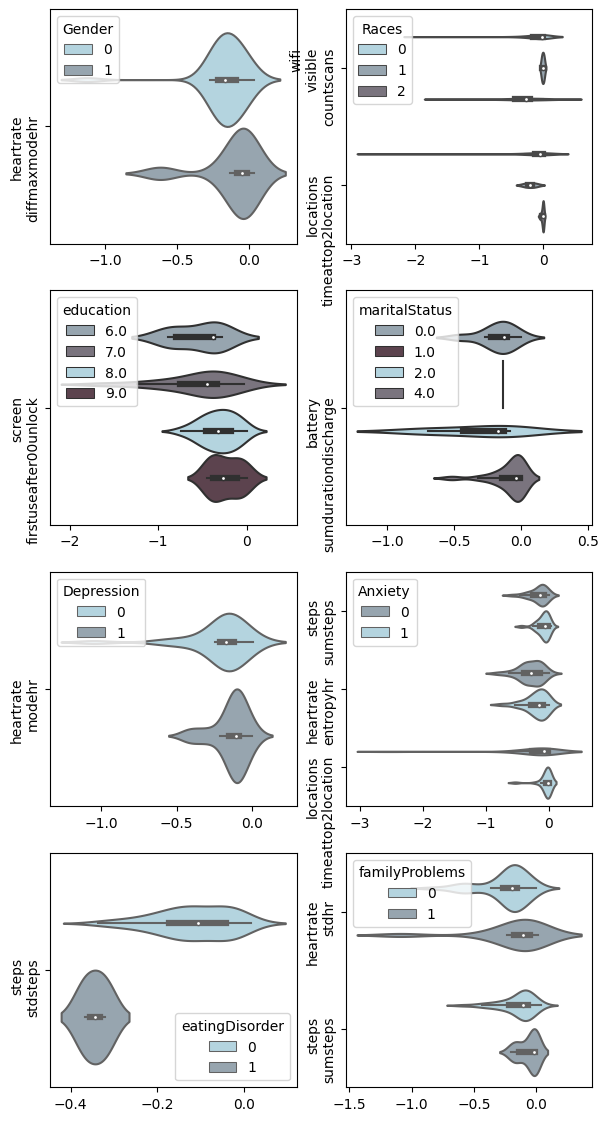

In [13]:
base_color = [173/255, 216/255, 230/255]  # This is light blue
merged_df = pd.merge(result, demo, on='participantID')

significant_shap_demos = []
alpha = 0.05

for demo_feature in demos:
    for shap_feature in selected:
        groups = []
        df_filtered = merged_df[[demo_feature, shap_feature]]

        for name, group in df_filtered.groupby(demo_feature):
            groups.append(group[shap_feature].values)

        try:
            H_stat, p_val = stats.kruskal(*groups)

            if p_val < alpha:
                significant_shap_demos.append((demo_feature, shap_feature, p_val))
        except ValueError as e:
            print(f"Skipping {demo_feature}, {shap_feature} due to error: {str(e)}")


_, corrected_p_vals, _, _ = multipletests([x[2] for x in significant_shap_demos], alpha=alpha, method='fdr_bh')
significant_shap_demos = [x for x, y in zip(significant_shap_demos, corrected_p_vals) if y < alpha]

unique_features = [x[1] for x in significant_shap_demos if x[0] in demos]
num_features = len(unique_features)

num_rows = 4 #int(np.sqrt(num_features))
num_cols = 2 #num_rows if num_rows * num_rows == num_features else num_rows + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 14))
axes = axes.ravel()

for idx, demo_feature in enumerate(demos):
    plot_df = pd.DataFrame()

    for i, shap_feature, _ in filter(lambda x: x[0] == demo_feature, significant_shap_demos):
        df_filtered = merged_df[[demo_feature, shap_feature]].copy()
        df_filtered['feature'] = shap_feature
        df_filtered.columns = [demo_feature, 'value', 'feature']
        df_filtered['feature'] = df_filtered['feature'].str.replace('_', '\n')
        plot_df = pd.concat([plot_df, df_filtered])

    if plot_df.empty:
        continue

    unique_demo_groups = plot_df[demo_feature].unique()
    num_demo_groups = len(unique_demo_groups)

    # Generating a list of shades of blue for the unique demo groups
    colors = [[max(0, base_color[0]-i*0.1), max(0, base_color[1]-i*0.2), max(0, base_color[2]-i*0.2)] for i in range(num_demo_groups)]

    color_dict = {demo_group: color for demo_group, color in zip(unique_demo_groups, colors)}

    sns.violinplot(data=plot_df, y='feature', x='value', hue=demo_feature, palette=color_dict, ax=axes[idx])
    #axes[idx].set_title('Boxplot of significant SHAP features across ' + demo_feature + ' groups')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')

    for label in axes[idx].get_yticklabels():
        label.set_rotation(90)


if idx < len(axes):
    for ax in axes[idx + 1:]:
        fig.delaxes(ax)

#plt.tight_layout()
plt.savefig('features.pdf')
plt.show()